In [1]:
from IPython.core.display import HTML
css_file = './notebook.css'
HTML(open(css_file, "r").read())

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.rpy.common as com
import pymc

prop = mpl.font_manager.FontProperties(fname='/Users/a-makabi/Library/Fonts/Ricty-Regular.ttf')
mpl.rcParams['font.family'] = prop.get_name()

plt.style.use('ggplot')
pd.options.display.mpl_style = 'default'

# 11章 空間構造のある階層ベイズモデル
空間構造のあるベイズモデル：階層ベイズモデルの応用例の1つ  
これまでは，データをとる場所の空間配置の影響を考えていなかった（e.g. 隣り合った鉢は似ているかもしれない）  
でも実は，各地点の観測値は独立でなく，相関があるかもしれない  
→ 場所差の __空間相関 (spatial correlation)__ を考慮した統計モデリングについて考える

## 11.1 例題：一次元空間上の個体数分布
どこかの森林で植物の個体数を記録した  
このとき，計算のため調査区画を50個設定した（この調査区画は1本の直線上に等間隔に配置される）

調査区画 $j$ で観察された個体数 $y_j$ は以下の通リ

In [4]:
# Y.RData download: http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html
df = pd.DataFrame({'Y': com.load_data('Y'), 'm': com.load_data('m')})
df.head()

,Y,m
1,0,2.154980
2,3,3.254165
3,2,4.628666
4,5,6.234124
5,6,7.990730


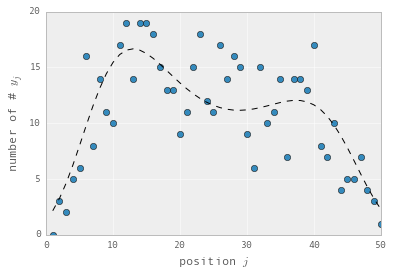

In [5]:
plt.plot(df.index, df.Y, 'o')
plt.plot(df.index, df.m, 'k--')
plt.xlabel('position $j$')
plt.ylabel('number of # $y_j$')

これらは場所 $j$ ごとに平均の異なるポアソン乱数として生成されている（図中の破線がその平均であり，これを__局所密度__と呼ぶ）  
近くにある $y_j$ の局所密度は似ている，つまり空間相関が生じている

## 11.2 階層ベイズモデルに空間構造をくみこむ
各調査区画で観測された個体数がどんな確率分布で表現出来るか考える  
仮に，すべての区画で平均 $\lambda$ が同じであるとすると以下の式で表せる

$$p(y_j|\lambda)=\frac{\lambda^{y_j}\exp(-\lambda)}{y_j!}$$

この仮定が正しい場合，標本平均は分散と同じぐらいになると期待できる

In [6]:
print("平均：{0}".format(df.Y.mean()))
print("分散：{0}".format(df.Y.var()))

平均：10.88
分散：27.373061224489792


分散が標本平均の3倍以上ある → データが__過分散__である

データをうまく表現するために，場所差を組み込んだ統計モデリングが必要である（区間 $j$ 毎に平均 $\lambda_j$ は異なる）  
50個のデータ ${\bf y}$ に対し50個の ${\bf \lambda}$ を最尤推定するのではなく，大域的な密度と局所的な差異を同時に組み込むことを考える．平均個体数 $\lambda_j$ を以下の通り表す

$$\log\lambda_j=\beta+r_j$$

- 切片 $\beta$：大域的なパラメータ．すべての場所に同じ影響を与える
- 場所差 $r_j$：局所的パラメータ．区間 $j$ のデータだけを説明する

大域的なパラメータの事前分布には無情報事前分布，局所的パラメータの事前分布には階層事前分布を利用する

### 11.2.1 空間構造のない階層事前分布
場所差 $r_j$ の__事前分布__を考える．10章で利用した階層事前分布を指定した場合，場所差 $r_j$ はどれも独立に同じ事前分布になるが，例題のような空間相関を仮定する状況ではこの仮定は成立しない  
※10章で利用した階層事前分布は以下の通リ（$r_j$ は平均ゼロで標準偏差 $s$ の正規分布）

$$p(r_j|s)=\frac{1}{\sqrt{2\pi s^2}}\exp\left(-\frac{r_j^2}{2s^2}\right)$$

### 11.2.2 空間構造のある階層事前分布
場所差 $r_i$ が位置によって変化する場合の__事前分布__を考える．簡単化のため，以下の仮定を設ける

- 区画の場所差は「近傍」区画のみに影響される
- 区画 $j$ の近傍の個数 $n_j$ は有限であり，近傍の定義はモデル設計者が決定する
- 近傍の直接の影響はどれも等しく $1/n_j$

更に簡単化するため，近傍の定義を隣接する区画だけとおく（すなわち近傍数 $n_j=2$）  
※ただし， $j\in{1,50}$ の場合は近傍数 $n_j=1$

このように相互作用の範囲を限定し， $r_j$ の近傍である $r_{j-1}$ と $r_{j+1}$ の値を固定した場合に， $r_j$ の条件付き事前分布を次のような正規分布であると設定する

$$p(r_j|\mu_j,s)=\sqrt{\frac{n_j}{2\pi s^2}}\exp\left\{-\frac{(r_j-\mu_j)^2}{2s^2/n_j}\right\}$$

このとき，正規分布の平均 $\mu_j$ は近傍である $r_{j-1}$ と $r_{j+1}$ の平均値に等しい  
※ただし， $j=1$，$j=50$ の場合は $\mu_1=r_2$，$\mu_2=r_{49}$ で，標準偏差は $s/\sqrt{n_j}$  
※10章では，平均ゼロで標準偏差 $s$ の正規分布と仮定していた

確率分布のパラメータ $s$ はどの場所でも同じであると仮定  
※10章では，$0<s<10^4$ の範囲の実数であれば，どの値であっても出現確率が等しくなる確率分布としていた  
※10章によれば，事前分布のパラメータ $s$ は超パラメータと呼ばれる

このような事前分布を，__条件付き自己回帰 (conditional auto regressive, CAR)__ モデルと呼ぶ  
この例題のように，さまざまな制約をつけて簡単化したものは特に __intrinsic Gaussian CAR__ モデルに分類される

場所差全体の事前分布である同時分布 $p(\{r_i\}|s)$ は以下のとおり書ける

$$p(\{r_j\}|s)\propto\exp\left\{\frac{1}{2s^2}\sum_{j〜j'}(r_j-r_{j'})^2\right\}$$

ここで $j〜j'$ は，ある区画 $j$ と別の区画 $j'$ が近傍であるようなすべての $\{j,j'\}$ の組み合わせ

## 11.3 空間統計モデルをデータにあてはめる
事後分布は以下のようになる

$$p(\beta,s,\{r_j\}|{\bf Y})\propto p(\{r_j\}|s)p(s)p(\beta)\prod_jp(y_j|\lambda_j)$$

データ $y_i$ が得られる確率 $p(y_j|\lambda_j)$ は平均 $\lambda_j=\exp(\beta+r_j)$ のポアソン分布とした  

- 切片 $\beta$：大域的なパラメータであるため，事前分布は__無情報事前分布__ $p(\beta)$ を指定する
- 場所差 $r_j$：局所的なパラメータである．事前分布は，__空間相関を考慮した__階層事前分布となる

空間相関がない場合については，p.228を参照

In [7]:
# intrinsic Gaussian CARモデルから {rj} のMCMCサンプルを発生させる準備

## 隣接する場所の番号 j
Adj = [[j-1, j+1] for j in np.arange(df.Y.size)]
Adj[0] = [1]
Adj[-1] = [49]
Adj = np.asarray(Adj)
print("隣接する場所の番号 j (Adj): \n\n{0}\n".format(Adj))

## Adj に対応する重み
## 注釈1より，どの場所に対しても1という重みを指定
Weights = np.asarray([[len(j) ** (-1)] * len(j) for j in Adj])
print("Adjに対応する重み (Weights): \n\n{0}\n".format(Weights))

## それぞれの区画に隣接する場所の数nj
Num = np.asarray([len(j) for j in Adj])
print("それぞれの区画に隣接する場所の数nj (Num): \n\n{0}\n".format(Num))

隣接する場所の番号 j (Adj): 

[[1] [0, 2] [1, 3] [2, 4] [3, 5] [4, 6] [5, 7] [6, 8] [7, 9] [8, 10]
 [9, 11] [10, 12] [11, 13] [12, 14] [13, 15] [14, 16] [15, 17] [16, 18]
 [17, 19] [18, 20] [19, 21] [20, 22] [21, 23] [22, 24] [23, 25] [24, 26]
 [25, 27] [26, 28] [27, 29] [28, 30] [29, 31] [30, 32] [31, 33] [32, 34]
 [33, 35] [34, 36] [35, 37] [36, 38] [37, 39] [38, 40] [39, 41] [40, 42]
 [41, 43] [42, 44] [43, 45] [44, 46] [45, 47] [46, 48] [47, 49] [49]]

Adjに対応する重み (Weights): 

[[1.0] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5]
 [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5]
 [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5]
 [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5]
 [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5]
 [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5]
 [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5]
 [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5

In [8]:
# p.248 よりパラメータ値を指定
beta = pymc.Normal('beta', mu=0, tau=1.0e-4)
s = pymc.Uniform('s', lower=0, upper=1.0e+4)
tau = pymc.Lambda('tau', lambda s=s: 1.0 / s ** 2)  # 分散の逆数

In [9]:
# PyMCの参考：http://www.slideshare.net/shima__shima/2014-mtokyoscipy6

## stochastic: グラフィカルモデルに現れるノード
## 親ノードの値が決まっても変数の値は確率的にふるまう
@pymc.stochastic
def R(tau=tau, value=np.zeros(df.Y.size)):
    mu = np.asarray([sum(Weights[j] * value[Adj[j]]) / Num[j] for j in np.arange(df.Y.size)])
    taux = tau * Num
    return pymc.normal_like(value, mu, taux)

## deterministic: グラフィカルモデルに現れないノード 
## 親ノードの値が決まれば値が決まる
@pymc.deterministic
def mean(beta=beta, R=R):
    return [np.exp(beta + R[j]) for j in np.arange(df.Y.size)]

In [10]:
observed = pymc.Poisson("observed", mu=mean, value=df.Y.values, observed=True)  # 観測変数
model = pymc.Model([s, beta, observed])

In [18]:
mcmc = pymc.MCMC(model)
mcmc.sample(iter=25000, burn=1000, thin=10)

 [-----------------100%-----------------] 25000 of 25000 complete in 24.3 sec

Plotting beta


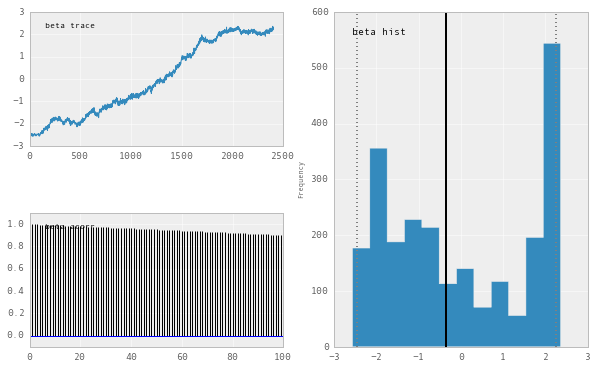

In [19]:
# サンプリング過程の可視化
pymc.Matplot.plot(mcmc.trace("beta"), common_scale=False)

Plotting s


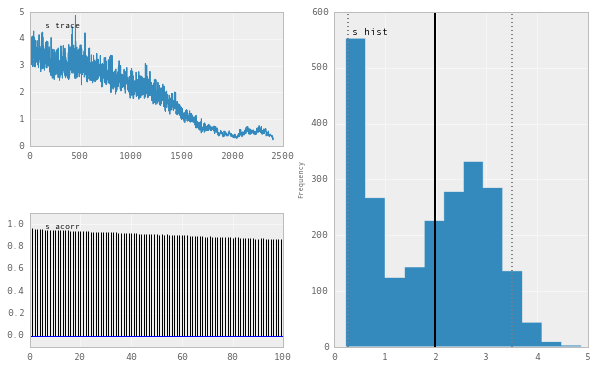

In [20]:
# サンプリング過程の可視化
pymc.Matplot.plot(mcmc.trace("s"), common_scale=False)

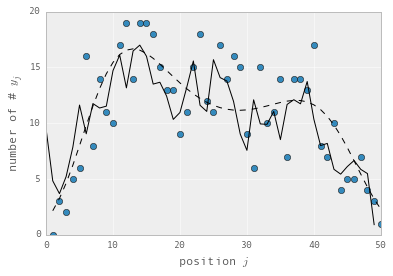

In [21]:
burnin = 2000
beta = np.mean(mcmc.trace('beta')[burnin:, None].flatten())
R = np.mean(mcmc.trace("R")[burnin:, None], axis=0).flatten()

x = np.arange(df.Y.size)
y = np.exp(beta + R)

plt.plot(df.index, df.Y, 'o')
plt.plot(df.index, df.m, 'k--')
plt.plot(x, y, 'k-')

plt.xlabel('position $j$')
plt.ylabel('number of # $y_j$')
plt.show()

## 11.4 空間統計モデルが作り出す確率場
結果を利用して統計モデルの挙動を理解する  
一般に，相互作用する確率変数たちでうめつくされた空間は__確率場 (random field)__ とよばれ，ここに登場する $\{r_j\}$ も確率場の一種である  
ここでは，ばらつきパラメータ $s$ の大小が確率場 $\{r_j\}$ にあたえる影響を図示する  
この章の例題データとその統計モデルで定義される $\{r_j\}$ の事後分布からのサンプリング例を以下に示す．ただし，大域的なパラメータ $\beta$ と $s$ には，てきとうな定数を与えて固定している

- $\beta$：2.27
- $s$：0.0316, 0.224, 10.0 ( $s^2$：0.001, 0.05, 100)

※注意：

- うまくいかなかったのでちょっとやり方を変えている（本の方がもっと顕著）
- 上の実験の段階で収束していない場合は大体うまくいかない

In [22]:
print(beta)  # ベータの値はこれで

2.12733660062


In [23]:
# sの値の変更を以下の通リとする
S = list(mcmc.trace('s')[burnin:, None].flatten())
print(min(S))           # min
print(max(S))          # max

S_idx = [S.index(min(S)), S.index(max(S))]

0.231114932188
0.757268026541


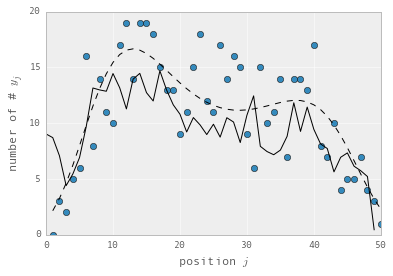

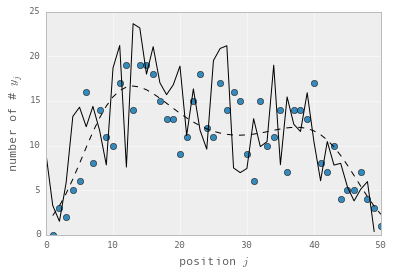

In [24]:
for idx in S_idx:
    R = mcmc.trace('R')[burnin:, None][idx].flatten()
    
    x = np.arange(df.Y.size)
    y = np.exp(beta + R)

    plt.plot(df.index, df.Y, 'o')
    plt.plot(df.index, df.m, 'k--')
    plt.plot(x, y, 'k-')

    plt.xlabel('position $j$')
    plt.ylabel('number of # $y_j$')
    plt.show()

$s$ が小さい場合は「両隣の平均と似ている」傾向が強くなり $r_j$ 全体のばらつきは小さくなる  
逆に $s$ が大きい場合は各 $r_j$ は隣とは無関係に値を選べるようになり，各 $j$ ごとにデータにあわせようとするので全体にぎざぎざした，ばらつきの大きい確率場になる

この確率場は少数の大域的パラメータ（この例題の場合は $s$ だけ）にコントロールされていて，これが局所的なパラメータ $r_j$ の階層的な事前分布となっている  
それぞれの $r_j$ は独立した確率変数ではなく，隣にいる $\{r_{j±1}\}$ と $s$ で決められている

## 11.5 空間相関モデルと欠測のある観測データ
空間相関を組み込んだ階層ベイズモデルは，欠損値に強くなる  
たとえば，以下のような__欠測データ (missing data)__ について考える

In [25]:
df['is_lack'] = np.zeros(df.Y.size)
for i in [5, 8, 11, 12, 25, 26, 27, 28, 29]:
    df.ix[i, 2] = 1
df.head(6)

,Y,m,is_lack
1,0,2.154980,0
2,3,3.254165,0
3,2,4.628666,0
4,5,6.234124,0
5,6,7.990730,0
6,16,9.794474,1


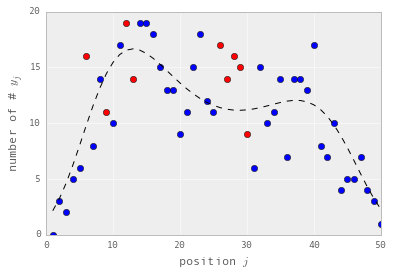

In [27]:
x = np.arange(df.Y.size)
y = np.exp(beta + R)

plt.plot(df[df.is_lack == 0].index, df[df.is_lack == 0].Y, 'o', color='blue')
plt.plot(df[df.is_lack == 1].index, df[df.is_lack == 1].Y, 'o', color='red')
plt.plot(df.index, df.m, 'k--')

plt.xlabel('position $j$')
plt.ylabel('number of # $y_j$')

このデータに対して，空間統計モデルと空間相関を無視した階層ベイズモデル，双方をあてはめてみる  
まず空間統計モデルについて見てみる

In [28]:
# intrinsic Gaussian CARモデルから {rj} のMCMCサンプルを発生させる準備

## 隣接する場所の番号 j
Adj = [[j-1, j+1] for j in np.arange(df[df.is_lack == 0].Y.size)]
Adj[0] = [1]
Adj[-1] = [df[df.is_lack == 0].Y.size - 1]
Adj = np.asarray(Adj)
print("隣接する場所の番号 j (Adj): \n\n{0}\n".format(Adj))

## Adj に対応する重み
## 注釈1より，どの場所に対しても1という重みを指定
Weights = np.asarray([[len(j) ** (-1)] * len(j) for j in Adj])
print("Adjに対応する重み (Weights): \n\n{0}\n".format(Weights))

## それぞれの区画に隣接する場所の数nj
Num = np.asarray([len(j) for j in Adj])
print("それぞれの区画に隣接する場所の数nj (Num): \n\n{0}\n".format(Num))

隣接する場所の番号 j (Adj): 

[[1] [0, 2] [1, 3] [2, 4] [3, 5] [4, 6] [5, 7] [6, 8] [7, 9] [8, 10]
 [9, 11] [10, 12] [11, 13] [12, 14] [13, 15] [14, 16] [15, 17] [16, 18]
 [17, 19] [18, 20] [19, 21] [20, 22] [21, 23] [22, 24] [23, 25] [24, 26]
 [25, 27] [26, 28] [27, 29] [28, 30] [29, 31] [30, 32] [31, 33] [32, 34]
 [33, 35] [34, 36] [35, 37] [36, 38] [37, 39] [38, 40] [40]]

Adjに対応する重み (Weights): 

[[1.0] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5]
 [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5]
 [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5]
 [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5]
 [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5]
 [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [0.5, 0.5]
 [0.5, 0.5] [0.5, 0.5] [0.5, 0.5] [1.0]]

それぞれの区画に隣接する場所の数nj (Num): 

[1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1]



In [29]:
# p.248 よりパラメータ値を指定
beta = pymc.Normal('beta', mu=0, tau=1.0e-4)
s = pymc.Uniform('s', lower=0, upper=1.0e+4)
tau = pymc.Lambda('tau', lambda s=s: 1.0 / s ** 2)  # 分散の逆数

In [30]:
# PyMCの参考：http://www.slideshare.net/shima__shima/2014-mtokyoscipy6

## stochastic: グラフィカルモデルに現れるノード
## 親ノードの値が決まっても変数の値は確率的にふるまう
@pymc.stochastic
def R(tau=tau, value=np.zeros(df[df.is_lack == 0].Y.size)):
    mu = np.asarray([sum(Weights[j] * value[Adj[j]]) / Num[j] for j in np.arange(df[df.is_lack == 0].Y.size)])
    taux = tau * Num
    return pymc.normal_like(value, mu, taux)

## deterministic: グラフィカルモデルに現れないノード 
## 親ノードの値が決まれば値が決まる
@pymc.deterministic
def mean(beta=beta, R=R):
    return [np.exp(beta + R[j]) for j in np.arange(df[df.is_lack == 0].Y.size)]

In [31]:
observed = pymc.Poisson("observed", mu=mean, value=df[df.is_lack == 0].Y.values, observed=True)  # 観測変数
model = pymc.Model([s, beta, observed])

In [33]:
mcmc = pymc.MCMC(model)
mcmc.sample(iter=25000, burn=1000, thin=10)

 [-----------------100%-----------------] 25000 of 25000 complete in 63.2 sec

Plotting beta


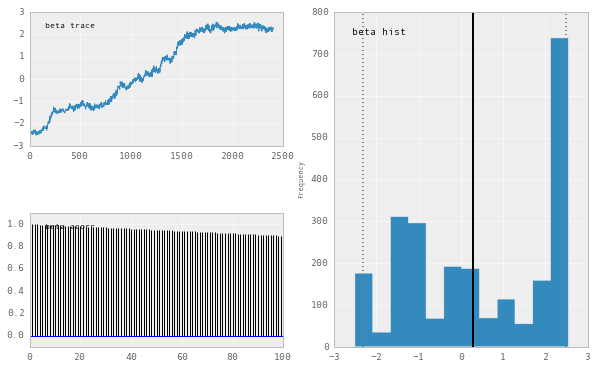

In [34]:
# サンプリング過程の可視化
pymc.Matplot.plot(mcmc.trace("beta"), common_scale=False)

Plotting s


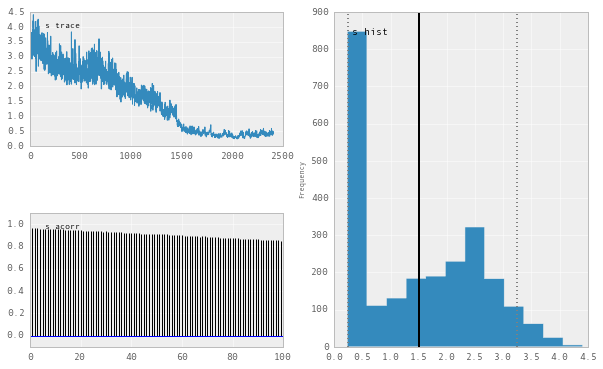

In [35]:
# サンプリング過程の可視化
pymc.Matplot.plot(mcmc.trace("s"), common_scale=False)

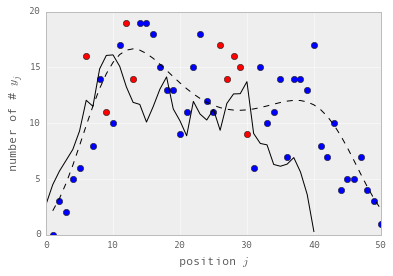

In [36]:
burnin = 1800
beta = np.mean(mcmc.trace('beta')[burnin:, None].flatten())
R = np.mean(mcmc.trace("R")[burnin:, None], axis=0).flatten()

x = np.arange(df[df.is_lack == 0].Y.size)
y = np.exp(beta + R)

plt.plot(df[df.is_lack == 0].index, df[df.is_lack == 0].Y, 'o', color='blue')
plt.plot(df[df.is_lack == 1].index, df[df.is_lack == 1].Y, 'o', color='red')
plt.plot(df.index, df.m, 'k--')
plt.plot(x, y, 'k-')

plt.xlabel('position $j$')
plt.ylabel('number of # $y_j$')
plt.show()

※何かうまくいってない気がするのですが本のまま進めます  
※多分欠損値を省いて離れた値を「隣」と定義してしまっている辺りが違う

結果は，欠測データがない場合とあまり変わっていない  
これは，隣同士の $r_j$ の相互作用をうまく利用できたためである

次に，空間相関を考慮しないモデルについて考える  
これは区画 $j$ ごとに独立な場所差 $r_j$ を仮定することになり，すべての $r_j$ の共通の事前分布は以下のとおり設定されていることになる（前章の階層ベイズモデルと同じである）

In [37]:
# p.248 よりパラメータ値を指定
beta = pymc.Normal('beta', mu=0, tau=1.0e-4)
s = pymc.Uniform('s', lower=0, upper=1.0e+4)
tau = pymc.Lambda('tau', lambda s=s: 1.0 / s ** 2)  # 分散の逆数

## stochastic: グラフィカルモデルに現れるノード
## 親ノードの値が決まっても変数の値は確率的にふるまう
@pymc.stochastic
def R(tau=tau, value=np.zeros(df[df.is_lack == 0].Y.size)):
    mu = 0  # muをゼロとする
    return pymc.normal_like(value, mu, tau)

## deterministic: グラフィカルモデルに現れないノード 
## 親ノードの値が決まれば値が決まる
@pymc.deterministic
def mean(beta=beta, R=R):
    return [np.exp(beta + R[j]) for j in np.arange(df[df.is_lack == 0].Y.size)]

In [38]:
observed = pymc.Poisson("observed", mu=mean, value=df[df.is_lack == 0].Y.values, observed=True)  # 観測変数
model = pymc.Model([s, beta, observed])

In [45]:
mcmc = pymc.MCMC(model)
mcmc.sample(iter=25000, burn=1000, thin=10)

 [-----------------100%-----------------] 25000 of 25000 complete in 30.7 sec

Plotting beta


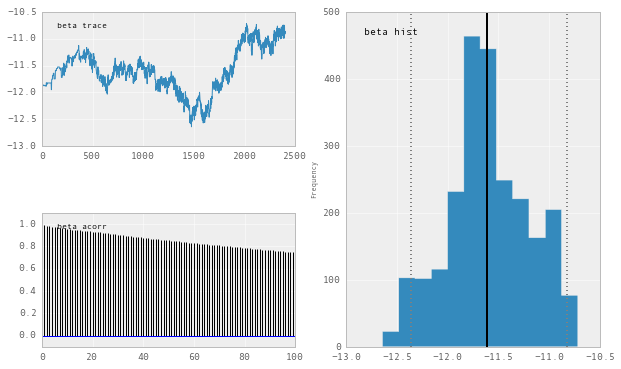

In [46]:
# サンプリング過程の可視化
pymc.Matplot.plot(mcmc.trace("beta"), common_scale=False)

Plotting beta


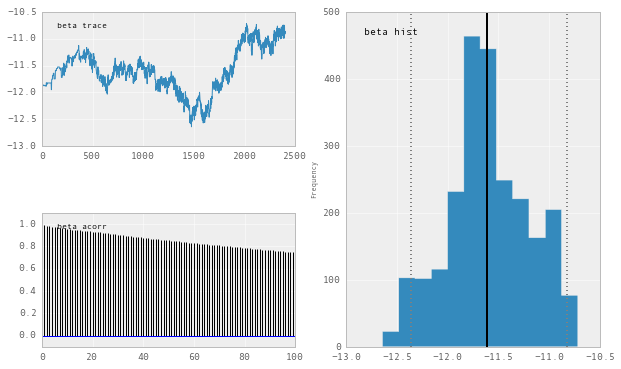

In [47]:
# サンプリング過程の可視化
pymc.Matplot.plot(mcmc.trace("beta"), common_scale=False)

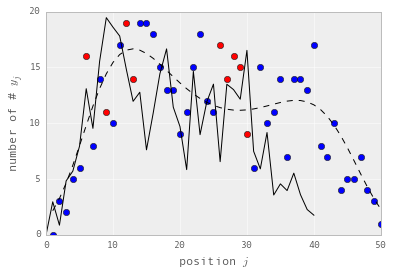

In [48]:
burnin = 2000
beta = np.mean(mcmc.trace('beta')[burnin:, None].flatten())
R = np.mean(mcmc.trace("R")[burnin:, None], axis=0).flatten()

x = np.arange(df[df.is_lack == 0].Y.size)
y = np.exp(beta + R)

plt.plot(df[df.is_lack == 0].index, df[df.is_lack == 0].Y, 'o', color='blue')
plt.plot(df[df.is_lack == 1].index, df[df.is_lack == 1].Y, 'o', color='red')
plt.plot(df.index, df.m, 'k--')
plt.plot(x, y, 'k-')

plt.xlabel('position $j$')
plt.ylabel('number of # $y_j$')
plt.show()

予測された局所密度は，各区間のデータ $y_j$ にあわせようとするためぎざぎざしている  
データがない区画では $r_j$ を決めようがなく，そのために予測区間の幅が大きくなる

実際には，データを見ているだけでは空間相関は読み取れない  
ひとつの方法として，空間構造のあるベイズ統計モデルをあてはめてみて，その中の「隣との類似」をあらわすパラメータ（この例題の場合は $s$ ）を推定してみたらよいだろう

## 11.6 この章のまとめと参考文献
本を参照